In [1]:
import numpy as np
import yaml
import os
import shutil
import glob
from ase.db import connect
from ase.io import read, write
from ase.visualize import view
from ase.calculators.eam import EAM
from ase.build import bulk
from ase import Atoms
from ase.geometry import cell_to_cellpar, cellpar_to_cell
import pandas as pd

from scipy import interpolate

# from gpaw import GPAW
from ase.calculators.emt import EMT
import json

import matplotlib.pyplot as plt

from pymatgen.ext.matproj import MPRester
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

from ase.io.lammpsdata import write_lammps_data, read_lammps_data

mpr = MPRester("X95IHGgtNwjR1xILRRk9NImcElr5JlTH")


In [2]:
tmp = read("/Users/Michael_wang/Downloads/xyz-npt-cp.dump", index=':')
for i in range(len(tmp)):
    del tmp[i][:480]
write("/Users/Michael_wang/Downloads/xyz-npt-cp-noLiCl.xyz", tmp)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Michael_wang/Downloads/xyz-npt-cp.dump'

In [2]:
numOfX = 5
initialTemp = "300.0"
alloySystem = "LiKCl-CHGNET"
potentialPath = "/ocean/projects/cts180021p/wuziqi/clease/mint-PD/PhaseDiagram-Clease/Liquid/GAP_potential/gap_LiKCl.xml"
chgnetDriverPath = "/ocean/projects/cts180021p/wuziqi/clease/lammps-ASC/potentials/CHGNET"
model_name = "MPtrj-efsm"
multipicity = (16,4,8)

end0StructureMPid = 'mp-22905'
# end1StructureMPid = 'mp-22983'
end1StructureMPid = 'mp-23193'


structure = mpr.get_structure_by_material_id(end0StructureMPid)
sg_analyzer = SpacegroupAnalyzer(structure)
primitive_structure = sg_analyzer.get_conventional_standard_structure()
ase_atoms0 = AseAtomsAdaptor.get_atoms(primitive_structure)
cell0 = ase_atoms0.cell
ase_atoms0.set_cell(cell0.cellpar()[:3]*2*2.55/cell0.cellpar()[0], scale_atoms=True)
view(ase_atoms0)

structure = mpr.get_structure_by_material_id(end1StructureMPid)
sg_analyzer = SpacegroupAnalyzer(structure)
primitive_structure = sg_analyzer.get_conventional_standard_structure()
ase_atoms1 = AseAtomsAdaptor.get_atoms(primitive_structure)
cell1 = ase_atoms1.cell
ase_atoms1.set_cell(cell1.cellpar()[:3]*2*3.18/cell1.cellpar()[0], scale_atoms=True)
view(ase_atoms1)

scaledCell = np.linspace(cell0, cell1, 10001, endpoint=True)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [44]:
tmp = ase_atoms1.cell * [1,1,1]

In [45]:
ase_atoms1.cell * [1,2,1] + tmp

array([[12.72,  0.  ,  0.  ],
       [ 0.  , 19.08,  0.  ],
       [ 0.  ,  0.  , 12.72]])

In [46]:
tmp

array([[6.36, 0.  , 0.  ],
       [0.  , 6.36, 0.  ],
       [0.  , 0.  , 6.36]])

In [33]:
# Define the supercell dimensions
supercell_dims = (4, 4, 1)
supercellCellSize = np.zeros((3,3))
supercellCellSize = ase_atoms0.cell * [0,4,1]

origin = np.array([0.0,0.0,0.0])

# Create a new Atoms object to store the supercell
supercell = Atoms()

NSpecies2Change = 11

count = 0
toBeAdded = np.zeros((3,3))

# Loop over the supercell dimensions and append copies of the unit cell
for i in range(supercell_dims[0]):
    for j in range(supercell_dims[1]):
        # Create a copy of the unit cell
        cell_copy = ase_atoms0.copy()
        
        # Decide whether change species 
        if count < NSpecies2Change:
            cell_copy.numbers[cell_copy.numbers == 3] = 19
            count += 1

            if (i + 1) * supercell_dims[1] <= NSpecies2Change:
                cellCopyScaledCellPar = list(cell_copy.cell.cellpar()[:3])
                cellCopyScaledCellPar[0] = 2*3.18
                cell_copy.set_cell(cellCopyScaledCellPar, scale_atoms=True)
        
        toBeAdded[0] = (cell_copy.cell*[1,1,1])[0]

        cell_copy.translate(origin)
        origin += cell_copy.cell.dot([0,1,0])
        
        # Append the translated copy to the supercell
        supercell.extend(cell_copy)
        
    supercellCellSize += toBeAdded
    origin[1] = 0
    origin += cell_copy.cell.dot([1,0,0])
    supercell.set_cell(supercellCellSize)

# Wrap the atoms inside the supercell
supercell.center()
supercell *= (1,1,12)
view(supercell)

[[ 0.   0.   0. ]
 [ 0.  20.4  0. ]
 [ 0.   0.   5.1]]
[[ 0.   0.   0. ]
 [ 0.  20.4  0. ]
 [ 0.   0.   5.1]]
[[ 0.   0.   0. ]
 [ 0.  20.4  0. ]
 [ 0.   0.   5.1]]
[[ 0.   0.   0. ]
 [ 0.  20.4  0. ]
 [ 0.   0.   5.1]]
[[ 6.36  0.    0.  ]
 [ 0.   20.4   0.  ]
 [ 0.    0.    5.1 ]]
[[ 6.36  0.    0.  ]
 [ 0.   20.4   0.  ]
 [ 0.    0.    5.1 ]]
[[ 6.36  0.    0.  ]
 [ 0.   20.4   0.  ]
 [ 0.    0.    5.1 ]]
[[ 6.36  0.    0.  ]
 [ 0.   20.4   0.  ]
 [ 0.    0.    5.1 ]]
[[12.72  0.    0.  ]
 [ 0.   20.4   0.  ]
 [ 0.    0.    5.1 ]]
[[12.72  0.    0.  ]
 [ 0.   20.4   0.  ]
 [ 0.    0.    5.1 ]]
[[12.72  0.    0.  ]
 [ 0.   20.4   0.  ]
 [ 0.    0.    5.1 ]]
[[12.72  0.    0.  ]
 [ 0.   20.4   0.  ]
 [ 0.    0.    5.1 ]]
[[17.82  0.    0.  ]
 [ 0.   20.4   0.  ]
 [ 0.    0.    5.1 ]]
[[17.82  0.    0.  ]
 [ 0.   20.4   0.  ]
 [ 0.    0.    5.1 ]]
[[17.82  0.    0.  ]
 [ 0.   20.4   0.  ]
 [ 0.    0.    5.1 ]]
[[17.82  0.    0.  ]
 [ 0.   20.4   0.  ]
 [ 0.    0.    5.1 ]]


/var/folders/k_/jq6m6ps14v59j7zn4tqygzjr0000gn/T/ipykernel_66896/1503352107.py:65: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  supercell *= (1,1,12)


<Popen: returncode: None args: ['/Users/Michael_wang/opt/anaconda3/envs/casm...>

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [17]:
cell_copy.cell.dot([0,1,0])

array([0. , 5.1, 0. ])

In [ ]:
tmpAtoms = (ase_atoms0*multipicity).copy()
tmpAtoms.set_cell(scaledCell[idx], scale_atoms=True)
KIdx = np.arange(len(tmpAtoms.numbers))[tmpAtoms.numbers == 3]
NtoConvert = int(len(KIdx)*x)

In [4]:
def distance_matrix(points):
    # Convert the list of points to a NumPy array
    points_array = np.array(points)
    
    # Compute the squared Euclidean distances using broadcasting
    diff = points_array[:, np.newaxis, :] - points_array[np.newaxis, :, :]
    dist_matrix = np.sqrt(np.sum(diff**2, axis=-1))
    
    return dist_matrix

numOfX = 5
initialTemp = "300.0"
alloySystem = "LiKCl-CHGNET"
potentialPath = "/ocean/projects/cts180021p/wuziqi/clease/mint-PD/PhaseDiagram-Clease/Liquid/GAP_potential/gap_LiKCl.xml"
chgnetDriverPath = "/ocean/projects/cts180021p/wuziqi/clease/lammps-ASC/potentials/CHGNET"
model_name = "MPtrj-efsm"
multipicity = (4,4,12)

end0StructureMPid = 'mp-22905' #LiCl
end1StructureMPid = 'mp-22983' #LiAlCl₄
# end1StructureMPid = 'mp-23193' #KCl

structure0 = mpr.get_structure_by_material_id(end0StructureMPid)
structure1 = mpr.get_structure_by_material_id(end1StructureMPid)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
sg_analyzer = SpacegroupAnalyzer(structure0)
primitive_structure = sg_analyzer.get_conventional_standard_structure()
ase_atoms0 = AseAtomsAdaptor.get_atoms(primitive_structure)
ase_atoms0 *= (6,2,5)
cell0 = ase_atoms0.cell
# write("LiCl.pdb", ase_atoms0)
print(cell0)
view(ase_atoms0)

sg_analyzer = SpacegroupAnalyzer(structure1)
primitive_structure = sg_analyzer.get_conventional_standard_structure()
ase_atoms1 = AseAtomsAdaptor.get_atoms(primitive_structure)
ase_atoms1 *= (4,4,2)
cell1 = ase_atoms1.cell
tmpCharge = ase_atoms1.numbers.copy()
tmpCharge[tmpCharge == 3] = 1
tmpCharge[tmpCharge == 17] = -1
tmpCharge[tmpCharge == 13] = 3
ase_atoms1.set_initial_charges(tmpCharge)
# write("LiAlCl.pdb", ase_atoms1)
print(cell1)
# write_lammps_data("LiAlCl4.data", ase_atoms1, atom_style='full')
view(ase_atoms1)

Cell([[30.50546806859715, 0.0, 1.8679211913349644e-15], [-6.226403971116548e-16, 10.16848935619905, 6.226403971116548e-16], [0.0, 0.0, 25.421223390497623]])
Cell([[0.0, 27.831099425276054, 0.0], [26.23641824, 0.0, 0.0], [0.0, -1.2709987275775174, -25.669688623508403]])


/var/folders/k_/jq6m6ps14v59j7zn4tqygzjr0000gn/T/ipykernel_56442/2077918642.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  ase_atoms0 *= (6,2,5)
/var/folders/k_/jq6m6ps14v59j7zn4tqygzjr0000gn/T/ipykernel_56442/2077918642.py:13: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  ase_atoms1 *= (4,4,2)


<Popen: returncode: None args: ['/Users/Michael_wang/opt/anaconda3/envs/casm...>

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [12]:
a = np.array([[1,1,1], [2,2,2], [3,3,3], [1,2,1.5]])
b = [2.5,2.5,1.6]
a[np.logical_and(np.logical_and(a[:, 0] < b[0], a[:, 1] < b[1]), a[:, 2] < b[2])]


array([[1. , 1. , 1. ],
       [1. , 2. , 1.5]])

In [11]:
# Get the cell lengths and angles of each atoms object
cellpar1 = ase_atoms0.cell.cellpar()
cellpar2 = ase_atoms1.cell.cellpar()
print(f"{cellpar1}\n{cellpar2}")
# Convert cell lengths and angles to cell vectors
cell1 = cellpar_to_cell(cellpar1)
cell2 = cellpar_to_cell(cellpar2)
print(f"{cell1}\n{cell2}")

[30.50546807 10.16848936 25.42122339 90.         90.         90.        ]
[27.83109943 26.23641824 25.70113522 90.         92.83460546 90.        ]
[[30.50546807  0.          0.        ]
 [ 0.         10.16848936  0.        ]
 [ 0.          0.         25.42122339]]
[[27.83109943  0.          0.        ]
 [ 0.         26.23641824  0.        ]
 [-1.27099873  0.         25.66968862]]


In [25]:
# Get the positions of all atoms
positions = ase_atoms1.get_positions()

# Calculate the minimum and maximum coordinates along each axis
min_coords = np.min(positions, axis=0)
max_coords = np.max(positions, axis=0)

# Calculate the dimensions of the bounding box
dimensions = max_coords - min_coords

# Create a new orthogonal cell with the bounding box dimensions
new_cell = np.diag(dimensions)

# Create a new Atoms object with the orthogonal cell
new_atoms = Atoms(positions=positions, numbers=ase_atoms1.numbers, cell=new_cell, pbc=True)

# Wrap the atoms inside the new cell
new_atoms.center()
view(new_atoms)

<Popen: returncode: None args: ['/Users/Michael_wang/opt/anaconda3/envs/casm...>

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [9]:
new_atoms.cell.cellpar()

array([25.9464178 , 27.67579969, 24.45939515, 90.        , 90.        ,
       90.        ])

In [27]:
# Define the target box size
box_size = (30.75, 40, 27)

# Get the dimensions of each atoms object
dims1 = ase_atoms0.cell.cellpar()
dims2 = new_atoms.cell.cellpar()
print(dims1)
print(dims2)

# Calculate the separation distance along each axis
sep_x = box_size[0] - max(dims1[0], dims2[0])
sep_y = box_size[1] - (dims1[1] + dims2[1])
sep_z = box_size[2] - max(dims1[2], dims2[2])

# Create a new Atoms object with the target box size
combined_atoms = Atoms(cell=box_size, pbc=True)

# Add the first atoms object to the new Atoms object
combined_atoms.extend(ase_atoms0)

# Translate the second atoms object to be face to face and separated
translation = (sep_x/2 + 1.25, dims1[1] + sep_y/2 - 1.25, sep_z/2 - 1.25)
tmp = new_atoms.copy()
tmp.translate(translation)

# Add the second atoms object to the new Atoms object
combined_atoms.extend(tmp)

# Center the atoms in the box
combined_atoms.center()
write("combined.pdb", combined_atoms)
view(combined_atoms)

[30.50546807 10.16848936 25.42122339 90.         90.         90.        ]
[25.9464178  27.67579969 24.45939515 90.         90.         90.        ]


<Popen: returncode: None args: ['/Users/Michael_wang/opt/anaconda3/envs/casm...>

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [ ]:
tmp = read("/Users/Michael_wang/Documents/venkat/packmol-20.14.3/LiClAl/Li-Cl-Al.pdb")


In [135]:
V = 43*33*30
xLiAlCl = 0.35

# doesn't have to change, this is just to calculate the density
vLiCl = 6571.27
nLiCl = 400
vLiAlCl = 4685.927
nLiAlCl = 192

# number of atoms in the supercell for each crystal structure
NinLiClCrystal = 480
NinLiAlClCrystal = 768
print(f"xLiAlCl = {xLiAlCl}")

rhoLiCl = nLiCl / vLiCl
rhoLiAlCl = nLiAlCl / vLiAlCl

print(f"rhoLiCl = {rhoLiCl}, rhoLiAlCl = {rhoLiAlCl}")

rhoAvg = xLiAlCl*rhoLiAlCl + (1-xLiAlCl)*rhoLiCl
totalN = rhoAvg * V

print(f"averge rho = {rhoAvg}, totalN = {totalN}")

nLiAlCl = int(totalN / (6 + (1-xLiAlCl) * 2 / xLiAlCl))
nLiCl = int((totalN - 6*nLiAlCl)/2)

print(f"nLiAlCl = {nLiAlCl}, nLiCl = {nLiCl}")

nLiAlCl = nLiAlCl - NinLiAlClCrystal/6
nLiCl = nLiCl - NinLiClCrystal/2

print(f"free nLiAlCl = {nLiAlCl}, free nLiCl = {nLiCl}")

nLi = nLiCl + nLiAlCl
nCl = nLiCl + nLiAlCl * 4
nAl = nLiAlCl

print(f"nLi = {nLi}, nCl = {nCl}, nAl = {nAl}, actual total N = {nLi + nCl + nAl}")


xLiAlCl = 0.35
rhoLiCl = 0.06087103406190888, rhoLiAlCl = 0.040973749697765245
averge rho = 0.05390698453445861, totalN = 2294.8203316319027
nLiAlCl = 236, nLiCl = 439
free nLiAlCl = 108.0, free nLiCl = 199.0
nLi = 307.0, nCl = 631.0, nAl = 108.0, actual total N = 1046.0


In [30]:
# atoms = read("/Users/Michael_wang/Documents/venkat/packmol-20.14.3/LiClAl/Li-Cl-Al.pdb")
# atoms.set_cell(box_size)
tmpCharge = supercell.numbers.copy()
tmpCharge[tmpCharge == 3] = 1
tmpCharge[tmpCharge == 17] = -1
tmpCharge[tmpCharge == 19] = 1
supercell.set_initial_charges(tmpCharge)
write_lammps_data("tmp.data", atoms=supercell, atom_style='full')

In [47]:
!pwd

/Users/Michael_wang/Documents/venkat/mint-PD/PhaseDiagram-Clease/Liquid


x = 0.5
rhoAvg = (rhoLiCl + 3*rhoLiAlCl)/4

In [27]:
totalN = 10
xLiAlCl = 0.34
nLiAlCl = int(totalN / (6 + (1-xLiAlCl) * 2 / xLiAlCl))
nLiCl = int((totalN - 6*nLiAlCl)/2)
print(nLiAlCl, nLiCl)

1 2


LiAlCl4 = li + al + 4cl => 6
LiCl = li + cl => 2
2li + al + 5cl

N, xLiAlCl4

N = N_LiAlCl4 * 6 + N_LiCl * 2
N_LiAlCl4/N_LiCl = xLiAlCl4/(1-xLiAlCl4)
N_LiCl = N_LiAlCl4 * (1-xLiAlCl4) / xLiAlCl4

N = N_LiAlCl4 * 6 + N_LiAlCl4 * (1-xLiAlCl4) * 2 / xLiAlCl4
N = N_LiAlCl4 * (6 + (1-xLiAlCl4) * 2 / xLiAlCl4)
N_LiAlCl4 = N / (6 + (1-xLiAlCl4) * 2 / xLiAlCl4)

In [4]:
tmp = read("../train-stress.extxyz", index=':')
pass

In [10]:
tmp = bulk("Li", 'bcc', 3.51, cubic=True)*(20,10,10)
write_lammps_data("/Users/Michael_wang/Desktop/Li_bcc_4000_atoms_bulk.data", tmp, atom_style='full')
view(tmp)

<Popen: returncode: None args: ['/Users/Michael_wang/opt/anaconda3/envs/casm...>

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [ ]:
a = "abc"
a.count('a', )

In [6]:
atoms = bulk(name="LiCl", crystalstructure="rocksalt", a=5.08, b=5.08, c=5.08, alpha=90)
# atoms *= (9,9,3)
view(atoms)

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [9]:
structure = mpr.get_structure_by_material_id('mp-22905')
# structure = mpr.get_structure_by_material_id('mp-23193')
sg_analyzer = SpacegroupAnalyzer(structure)
primitive_structure = sg_analyzer.get_conventional_standard_structure()
ase_atoms = AseAtomsAdaptor.get_atoms(primitive_structure)
ase_atoms *= (3,3,6)
view(ase_atoms)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [6]:
import random

KIdx = np.arange(len(ase_atoms.numbers))[ase_atoms.numbers == 3]
toLi = random.sample(KIdx.tolist(), int(len(KIdx)*0.6))
ase_atoms.numbers[toLi] = 19
view(ase_atoms)

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [7]:

write_lammps_data(file="Li50K50Cl-solid.data", atoms=ase_atoms, atom_style="full")


In [31]:
frames = np.loadtxt("GAPlammps.out", skiprows=36, max_rows=401)

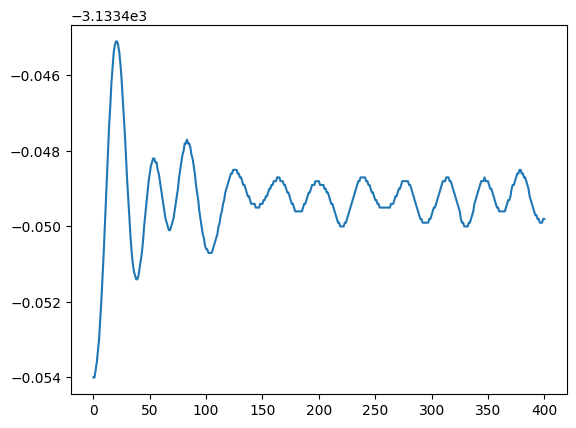

In [34]:
plt.plot(frames[:,4])

In [4]:
from ase.io import read
W = read('WL.traj')

In [5]:
view(W)
W.cell[1]

array([0.      , 4.901919, 0.      ])

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [6]:
from ase.build import fcc111
slab = fcc111('Ni', size=[2, 4, 3], a=3.55, orthogonal=True)

In [40]:
view(slab)

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [7]:
W.cell = [W.cell[1, 1], W.cell[0, 0], W.cell[2,2]]

In [8]:
W.rotate(90, 'z', center=(0, 0, 0))

In [71]:
view(W)

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [9]:
W.wrap()


In [72]:
W.cell

Cell([5.020458146424487, 8.695688586880282, 26.93236])

In [73]:
slab.cell

Cell([5.020458146424487, 8.695688586880282, 0.0])

In [10]:
W.set_cell([slab.cell[0], slab.cell[1], W.cell[2]], scale_atoms=True)

In [79]:
W.positions

array([[0.07919195, 0.28474836, 6.88673518],
       [1.05046136, 0.94053978, 6.83481037],
       [4.12863347, 0.94087516, 6.83252698],
       [2.5896971 , 1.9005956 , 6.98465318],
       [2.59999465, 3.21580833, 6.85300181],
       [2.59160125, 1.81860011, 8.08552648],
       [2.6109209 , 4.63176471, 6.79460275],
       [3.5829464 , 5.29392313, 6.84685463],
       [1.63995642, 5.28034857, 6.85082201],
       [0.07565183, 6.24939076, 6.69969482],
       [0.07618416, 7.56421525, 6.82838996],
       [0.08836217, 6.16435981, 5.59918691]])

In [75]:
slab.positions

array([[1.25511454, 0.72464072, 0.        ],
       [3.76534361, 0.72464072, 0.        ],
       [0.        , 2.89856286, 0.        ],
       [2.51022907, 2.89856286, 0.        ],
       [1.25511454, 5.07248501, 0.        ],
       [3.76534361, 5.07248501, 0.        ],
       [0.        , 7.24640716, 0.        ],
       [2.51022907, 7.24640716, 0.        ],
       [0.        , 1.44928143, 2.04959346],
       [2.51022907, 1.44928143, 2.04959346],
       [1.25511454, 3.62320358, 2.04959346],
       [3.76534361, 3.62320358, 2.04959346],
       [0.        , 5.79712572, 2.04959346],
       [2.51022907, 5.79712572, 2.04959346],
       [1.25511454, 7.97104787, 2.04959346],
       [3.76534361, 7.97104787, 2.04959346],
       [0.        , 0.        , 4.09918691],
       [2.51022907, 0.        , 4.09918691],
       [1.25511454, 2.17392215, 4.09918691],
       [3.76534361, 2.17392215, 4.09918691],
       [0.        , 4.34784429, 4.09918691],
       [2.51022907, 4.34784429, 4.09918691],
       [1.

In [11]:
zmin = W.positions[:, 2].min()
zmax = slab.positions[:, 2].max()

In [12]:
zmax - zmin

-8.079755888753654

In [13]:
W.positions += (0, 0, zmax - zmin + 1.5)

In [15]:
print("asdf")
a = 1+1
atoms = slab + W
pass

asdf


In [16]:
view(atoms)

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [4]:
from ase.io import extxyz
partB = ase_read("LiCl-melted-300k-1bar.xyz")
view(partB)

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [5]:
partB.cell

Cell([14.9346358135, 14.9579177688, 36.0565238594])

In [6]:
partA = ase_read("LiCl-solid-300k-1bar.xyz")

In [7]:
view(partA)

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [8]:
partA.cell

Cell([14.9346358135, 14.9579177688, 29.8824412932])

In [9]:
zmin = partB.positions[:, 2].min()
zmax = partA.positions[:, 2].max()
delta = zmax - zmin + 2.54
delta

35.29874

In [10]:
partB.cell[2,2]

36.0565238594

In [11]:
partB.positions += (0, 0, delta)

In [12]:
finalAtoms = partA + partB

In [13]:
view(finalAtoms)

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [14]:
from ase.io.lammpsdata import write_lammps_data
write_lammps_data(file="LiCl-mix.data", atoms=finalAtoms, atom_style="full")

In [15]:
finalAtoms.positions[:, 2].max()

68.52924

In [24]:
 with open("LiKCl/0.00x-LiKCl/123toABC.txt", 'r') as f:
    lmpAtomConversion = f.readline().split(' ')[1:]

In [25]:
lmpAtomConversion

['17', '3']

In [20]:
lmpAtomConversion

['', '17', '3']

In [5]:
structureA = read_lammps_data("LiKCl/0.00x-LiKCl/structureA.data")
for idx, i in enumerate(lmpAtomConversion):
    structureA.numbers[structureA.numbers == idx+1] = int(i)
    
structureB = read_lammps_data("LiKCl/0.00x-LiKCl/structureA.data")
for idx, i in enumerate(lmpAtomConversion):
    structureB.numbers[structureB.numbers == idx+1] = int(i)

In [6]:
zmin = structureB.positions[:, 2].min()
zmax = structureA.positions[:, 2].max()
delta = zmax - zmin + 2.5

In [7]:
structureB.positions += (0, 0, delta)
finalAtoms = structureA + structureB

In [8]:
view(finalAtoms)

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [15]:
dirs = os.listdir()

In [14]:
list(filter(('.DS_Store').__ne__, dirs))

['asdf.txt',
 'LiKCl-melted-300k-1bar.xyz',
 'LiCl-mix.data',
 'lastFrame.data',
 'Li50K50Cl-solid.data',
 'asdf.py',
 'LiKCl',
 'gap_LiKCl.xml',
 'test',
 'LiCl-melted-300k-1bar.xyz',
 'likcl-solid-300k-1bar.dump',
 'xyz-melt.dump',
 'LiCl.in',
 'likcl-solid-100k-1bar.data',
 'GAPlammps.out',
 'xyz-mix.dump',
 'WL.py',
 'run.sh',
 'LiCl-solid-300k-1bar.data',
 'step0.py',
 'relaxed-solid.data',
 'xyz-mix-900.dump',
 'likcl-solid-100k-1bar.dump',
 'LiCl-solid-300k-1bar.xyz',
 '~$liquid.docx',
 'asdf.ipynb',
 'liquid.docx',
 'step1.py',
 'xyz.dump',
 'LiCl-solid.data',
 'WL.traj',
 'xyz-mix-600k.dump',
 '.vscode',
 'xyz-fixed.dump',
 'tete.ipynb']

In [2]:
numOfT = 25
TInit, Tfinal = 300, 1200
np.linspace(TInit, Tfinal, numOfT)

sorted_indices = np.argsort(array_xy[:,0])

# Sort the array along the x-axis based on y[0]
sorted_array = array_xy[sorted_indices, :]

array([ 300. ,  337.5,  375. ,  412.5,  450. ,  487.5,  525. ,  562.5,
        600. ,  637.5,  675. ,  712.5,  750. ,  787.5,  825. ,  862.5,
        900. ,  937.5,  975. , 1012.5, 1050. , 1087.5, 1125. , 1162.5,
       1200. ])

In [218]:
frames = []
boxes = []
timestep_data = []

with open('/Users/Michael_wang/Documents/venkat/mint-PD/PhaseDiagram-Clease/Liquid/LiKCl-full/1.00x-LiKCl-full/xyz-mix.dump', 'r') as f:
# with open('/Users/Michael_wang/Documents/venkat/mint-PD/PhaseDiagram-Clease/Liquid/likcl-solid-300k-1bar.dump', 'r') as f:
# with open('/Users/Michael_wang/Documents/venkat/mint-PD/PhaseDiagram-Clease/Liquid/LiKCl-melted-300k-1bar.xyz', 'r') as f:
    for line in f:
        if line.startswith("ITEM: TIMESTEP"):
            # New timestep begins, store previous timestep data
            if timestep_data:
                tmp = np.array(timestep_data[0])
                tmp = tmp[np.argsort(tmp[:, 0]), :]
                frames.append(tmp[:, 1:])
                timestep_data = []
            next(f)  # skip the line containing the timestep value
        elif line.startswith("ITEM: BOX"):
            tmp = list(map(float, next(f).split()))
            x = tmp[1] - tmp[0]
            tmp = list(map(float, next(f).split()))
            y = tmp[1] - tmp[0]
            tmp = list(map(float, next(f).split()))
            z = tmp[1] - tmp[0]
            boxes.append(np.array([x, y, z]))
        elif line.startswith("ITEM: NUMBER OF ATOMS"):
            num_atoms = int(next(f))
        elif line.startswith("ITEM: ATOMS"):
            # Read atom coordinates for the current timestep
            timestep_data.append([list(map(float, next(f).split()[1:])) for _ in range(num_atoms)])
    
    if timestep_data:
        tmp = np.array(timestep_data[0])
        tmp = tmp[np.argsort(tmp[:, 0]), :]
        frames.append(tmp[:, 1:])
    
frames = np.array(frames)
boxes = np.array(boxes)

In [2]:
# def calculate_distance_periodic(initial_position, final_position, box_size):
#     displacement = final_position - initial_position

#     # Apply periodic boundary conditions
#     displacement = np.where(displacement > 0.5 * box_size, displacement - box_size, displacement)
#     displacement = np.where(displacement < -0.5 * box_size, displacement + box_size, displacement)

#     distance_traveled = np.linalg.norm(displacement)
#     return distance_traveled

# # Example usage
# initial_position = np.array([0.2, 0.3, 0.4])
# final_position = np.array([18.2, 0.1, 0.3])
# box_size = np.array([18.85, 18.85, 37.7])

# distance_traveled = calculate_distance_periodic(initial_position, final_position, box_size)
# print("Distance Traveled:", distance_traveled)

Distance Traveled: 0.8789197915623487


In [13]:
# boxes = np.array([
#     [4,4,4],
#     [4,4,4],
#     [4,4,4],
#     [4,4,4],
#     [4,4,4],
#     [4,4,4],
#     [4,4,4],
#     [4,4,4],
#     [4,4,4]
# ])
# frames = np.array([
#     [[0,0,0], [1,1,1]],
#     [[1,1,1], [2,2,2]],
#     [[0,1,1], [3,3,3]],
#     [[3,0,0], [4,4,4]],
#     [[0,3,3], [1,1,1]],
#     [[1.5,0,0], [2,2,2]],
#     [[0,0,3], [3,3,3]],
#     [[3,3,2.5], [4,4,4]],
#     [[0,0,0], [1,1,1]]
# ])



In [219]:
TotalDisplacement = []
displacementVar = []
displacements = []
start = 0
NumOfStep = 100

for idx, f in enumerate(frames):
    if idx < start:
        continue
    
    box_size = boxes[idx]
    # distance = f - frames[0]
    displacement = f - frames[idx-1]
    displacement = np.where(displacement > 0.5 * box_size, displacement - box_size, displacement)
    displacement = np.where(displacement < -0.5 * box_size, box_size + displacement, displacement)
    displacements.append(displacement)
    
    if idx < start+1:
        TotalDisplacement.append(displacement)
    else:
        TotalDisplacement.append(displacement + TotalDisplacement[-1])
    
    if idx >= start + NumOfStep:
        displacementVar.append(np.var(TotalDisplacement[-NumOfStep:], axis=0))
        
    

TotalDisplacement = np.array(TotalDisplacement)
displacementVar = np.array(displacementVar)
print(np.mean(TotalDisplacement[-1], axis=0))   
print(np.mean(TotalDisplacement[-1]))    
    
    

[ 0.00079618 -0.00022848  0.02371031]
0.008092672877857695


In [155]:
TotalDisplacement.shape

(401, 432, 3)

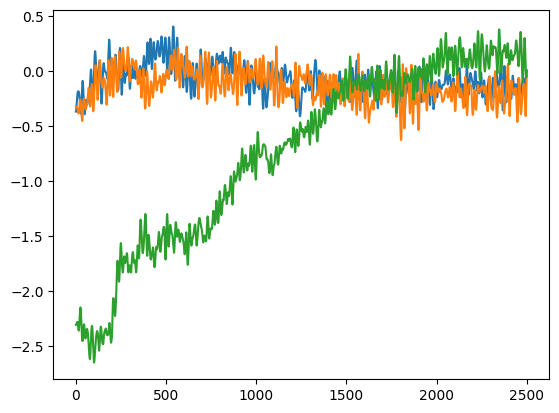

In [220]:
plt.plot(TotalDisplacement[:,100,0])
plt.plot(TotalDisplacement[:,100,1])
plt.plot(TotalDisplacement[:,100,2])

In [64]:
tmp = frames[:, :, :].copy()

In [65]:
tmp.shape

(391, 432, 3)

In [68]:
boxes[0]

array([15.25273403, 15.25273403, 30.50546807])

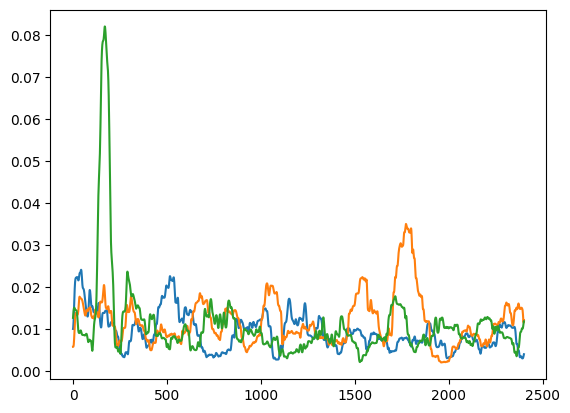

In [221]:
plt.plot(displacementVar[:,100,0])
plt.plot(displacementVar[:,100,1])
plt.plot(displacementVar[:,100,2])
# plt.ylim([2, 4])

In [181]:
tmp = np.mean(displacementVar, axis=0)
np.mean(tmp, axis=0)

array([0.02915454, 0.02894036, 0.02988794])

In [ ]:
array([0.00707131, 0.0067546 , 0.0073325 ])
array([0.02915454, 0.02894036, 0.02988794])
0.017

In [223]:
displacementVar.shape

(2401, 864, 3)

In [222]:
toTraj = np.ones(displacementVar.shape[:-1]+(displacementVar.shape[2]+1,))

In [224]:
toTraj[:,:,1:] = frames[-2401:]

In [209]:
toTraj[-1,0,:]

array([ 1.      ,  0.241993, 14.9365  ,  0.416536])

In [225]:
toTraj.shape

(2401, 864, 4)

In [213]:
tmp = np.mean(displacementVar[0], axis=1)
toTraj[0, :, 0].shape

(432,)

In [216]:
threshold = 0.016
for idx, f in enumerate(toTraj):
    tmp = np.mean(displacementVar[idx], axis=1)
    toTraj[idx, :, 0] = np.where(tmp > threshold, 2, 1)

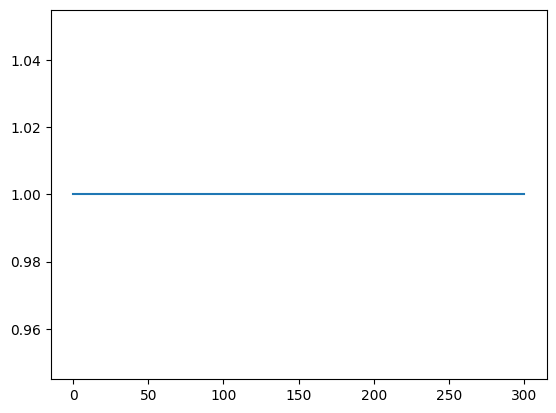

In [195]:
def write_multiframe_xyz(filename, frames_data):
    with open(filename, 'w') as f:
        for frame_data in frames_data:
            num_atoms = len(frame_data)
            f.write(f"{num_atoms}\n")
            f.write("Frame\n")
            for atom_data in frame_data:
                atom_type, x, y, z = atom_data
                f.write(f"{atom_type} {x} {y} {z}\n")

In [217]:
write_multiframe_xyz("processed-solid.xyz", toTraj)

In [ ]:
from ase import Atoms
from ase.db import connect
import numpy as np

def read_xyz_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Extract number of atoms from the first line
    num_atoms = int(lines[0])

    # Parse lattice information
    lattice_line = lines[1].split('=')
    lattice_params = np.array(list(map(float, lattice_line[1].split()))).reshape((3, 3))

    # Parse atomic positions
    atomic_data = []
    for line in lines[2:]:
        tokens = line.split()
        if len(tokens) == 7:  # Check for lines containing atomic information
            atom_type = tokens[0]
            x, y, z = map(float, tokens[1:4])
            atomic_data.append([atom_type, x, y, z])

    return num_atoms, lattice_params, atomic_data

def create_ase_atoms(num_atoms, lattice_params, atomic_data):
    symbols = [entry[0] for entry in atomic_data]
    positions = np.array([entry[1:4] for entry in atomic_data])

    atoms = Atoms(symbols=symbols, positions=positions, cell=lattice_params, pbc=True)
    return atoms


xyz_file_path = '/Users/Michael_wang/Documents/venkat/mint-PD/guo_gapml/POT/train (1).xyz'
db_file_path = 'output.db'

# Read data from XYZ file
num_atoms, lattice_params, atomic_data = read_xyz_file(xyz_file_path)

# Create ASE atoms object
atoms = create_ase_atoms(num_atoms, lattice_params, atomic_data)

# Save ASE atoms object to a .db file
with connect(db_file_path) as db:
    db.write(atoms)


In [ ]:
from ase import Atoms
from ase.io import write
import numpy as np

def read_multiframe_xyz(filename):
    frames_data = []
    with open(filename, 'r') as f:
        lines = f.readlines()
        num_frames = int(lines[0].strip())
        line_index = 1

        for _ in range(num_frames):
            # Read lattice information and other properties
            lattice_line = lines[line_index].split()
            lattice = np.array([float(x) for x in lattice_line[1:]])
            line_index += 1

            # Read atomic coordinates
            num_atoms = int(lines[line_index].strip())
            line_index += 1

            frame_data = []
            for _ in range(num_atoms):
                atom_info = lines[line_index].split()
                atom_type = atom_info[0]
                position = [float(x) for x in atom_info[1:4]]
                frame_data.append([atom_type] + position)
                line_index += 1

            frames_data.append((lattice, frame_data))

    return frames_data

def convert_to_ase_atoms(frames_data):
    atoms_list = []

    for lattice, frame_data in frames_data:
        symbols = [atom[0] for atom in frame_data]
        positions = [atom[1:] for atom in frame_data]
        atoms = Atoms(symbols=symbols, positions=positions, cell=lattice, pbc=True)
        atoms_list.append(atoms)

    return atoms_list

# Example usage
filename = '/Users/Michael_wang/Documents/venkat/mint-PD/guo_gapml/POT/train (1).xyz'
frames_data = read_multiframe_xyz(filename)
atoms_list = convert_to_ase_atoms(frames_data)

# Save ASE atoms into a .db file
write('output.db', atoms_list)


In [67]:
import re

frames = []
symbols = []
positions = []
fileName = '/Users/Michael_wang/Documents/venkat/mint-PD/guo_gapml/POT/train.xyz'

with open(fileName, 'r') as f:
    lines = f.readlines()
    with open ("/Users/Michael_wang/Documents/venkat/mint-PD/guo_gapml/POT/tansfered.extxyz", 'w') as fo:
        for l in lines:
            tmp = l.split()
            if len(tmp) == 1:
                fo.write(l)
            elif len(tmp) > 10:
                key_value_pairs = re.findall(r'(\w+)=(?:"([^"]*)"|(\S+))', l)
                key_value_pairs = [(tuple(x if x != '' else x for x in _ if x)) for _ in key_value_pairs]
                result_dict = dict(key_value_pairs)
                result_dict['energy'] = float(result_dict['energy'])/1000
                myStr = ''
                for k in result_dict:
                    if k in ["Lattice", "stress", "pbc"]:
                        myStr += k + "=\"" + str(result_dict[k]) + "\" "
                    else:
                        myStr += k + "=" + str(result_dict[k]) + " "
                myStr = myStr[0:-1] + '\n'
                fo.write(myStr)
                
            elif len(tmp) == 7:
                myStr = str(tmp[0]) + '\t' + str(tmp[1]) + '\t' + str(tmp[2]) + '\t' + str(tmp[3]) + '\t' + str(float(tmp[4])/1000) + '\t' + str(float(tmp[5])/1000) + '\t' + str(float(tmp[6])/1000) + '\n'
                fo.write(myStr)
            

In [58]:
a = "abc"
a[0:-1]

'ab'

In [45]:
tmp = "Lattice=\"13.76443408 0.0 0.0 0.0 13.76443408 0.0 0.0 0.0 13.76443408\" Properties=species:S:1:pos:R:3:forces:R:3 energy=-633.72651771 stress=\"-0.01178970331034305 0.0006205258378465037 0.0007445482192870606 0.0006205258378465037 -0.0026943470488568996 -0.00032411617624323284 0.0007445482192870606 -0.00032411617624323284 -0.010878252836630083\" free_energy=-633.72651771 pbc=\"T T T\" config_type=melt"
tt = tmp.split(" ")
print(len(tt))

25


In [47]:
import re

# r'(\w+)=(?:"([^"]*)"|(\S+))'
key_value_pairs = re.findall(r'(\w+)=(?:"([^"]*)"|(\S+))', tmp)
key_value_pairs = [(tuple(x if x != '' else x for x in _ if x)) for _ in key_value_pairs]
key_value_pairs


[('Lattice',
  '13.76443408 0.0 0.0 0.0 13.76443408 0.0 0.0 0.0 13.76443408',
  ''),
 ('Properties', '', 'species:S:1:pos:R:3:forces:R:3'),
 ('energy', '', '-633.72651771'),
 ('stress',
  '-0.01178970331034305 0.0006205258378465037 0.0007445482192870606 0.0006205258378465037 -0.0026943470488568996 -0.00032411617624323284 0.0007445482192870606 -0.00032411617624323284 -0.010878252836630083',
  ''),
 ('free_energy', '', '-633.72651771'),
 ('pbc', 'T T T', ''),
 ('config_type', '', 'melt')]

In [48]:
key_value_pairs = [(tuple(x if x != '' else x for x in _ if x)) for _ in key_value_pairs]
key_value_pairs

[('Lattice', '13.76443408 0.0 0.0 0.0 13.76443408 0.0 0.0 0.0 13.76443408'),
 ('Properties', 'species:S:1:pos:R:3:forces:R:3'),
 ('energy', '-633.72651771'),
 ('stress',
  '-0.01178970331034305 0.0006205258378465037 0.0007445482192870606 0.0006205258378465037 -0.0026943470488568996 -0.00032411617624323284 0.0007445482192870606 -0.00032411617624323284 -0.010878252836630083'),
 ('free_energy', '-633.72651771'),
 ('pbc', 'T T T'),
 ('config_type', 'melt')]

In [23]:
np.array(tmp, dtype=float).reshape(3,3)

array([[13.76443408,  0.        ,  0.        ],
       [ 0.        , 13.76443408,  0.        ],
       [ 0.        ,  0.        , 13.76443408]])

In [34]:
write('output.db', frames)

In [1]:
import ase
tmp = ase.io.read('/Users/Michael_wang/Documents/venkat/mint-PD/guo_gapml/POT/transfered.extxyz', ':')

AttributeError: module 'ase' has no attribute 'io'

In [4]:
with open('/Users/Michael_wang/Documents/venkat/mint-PD/guo_gapml/POT/transfered.extxyz', 'r') as f:
    for x in f.readlines()[-4:]:
        print(x)
    

K	0.00000000	0.00000000	0.00000000	0.0	0.0	0.0

1

Lattice="10.0 0.0 0.0 0.0 10.0 0.0 0.0 0.0 10.0" Properties=species:S:1:pos:R:3:forces:R:3 energy=-0.00043252054 stress="0.00010112488716699667 0.0 0.0 0.0 0.00010112488716699667 0.0 0.0 0.0 0.00010112488716699667" free_energy=-0.44662527 pbc="T T T" config_type=isolated_atom

Li	0.00000000	0.00000000	0.00000000	0.0	-0.0	-0.0



In [6]:
from ase.io import read, write
# tmp = ase.io.read("Cl30K3Li27_ID_213_scf_1.pwi.pwo")

In [4]:
xs = ["Cl30K3Li27_ID_214_scf_1.pwi.pwo", "Cl30K3Li27_ID_213_scf_1.pwi.pwo"]

In [7]:
myAtoms = []
for x in xs:
    myAtoms.append(read(x))

write("train.extxyz", myAtoms)

In [2]:
tmp = connect("/Users/Michael_wang/Documents/venkat/NequIP/try/NequIP-Tutorial-Duplicate (1)/nequip/nequip/scripts/benzene-asdf.db")
tmp.delete(range(1,49000))

In [12]:
a = []

if a == []:
    print(1)
else:
    print(2)

1


In [2]:
coreNum = [1,2,4,8,16]
lmpTime = np.array([184.125, 96.8288, 47.7304, 20.9744, 15.3383])
myTime = np.array([128.479, 55.937, 29.0859, 15.6195, 9.00446])

In [3]:
%matplotlib qt
plt.plot(coreNum, lmpTime/myTime, '-o')
# plt.plot(coreNum, , '-o')
plt.xscale("log")
# plt.yscale("log")
plt.xticks(ticks=[1,2,4,8,16], labels=["1","2","4","8","16"])
plt.xlabel("Number of Cores")
plt.ylabel("Bridges2 LAMMPS runtime / Custom LAMMPS runtime")
plt.ylim([0,2])
plt.show()

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [5]:
lmpSU = lmpTime[0]/lmpTime
mySU = myTime[0]/myTime

In [6]:
plt.plot(coreNum, lmpSU, '-o')
plt.plot(coreNum, mySU, '-o')
plt.legend(["Bridges2 LAMMPS", "Custom LAMMPS"])
plt.xscale("log")
plt.yscale("log")
plt.xticks(ticks=[1,2,4,8,16], labels=["1","2","4","8","16"])
plt.xlabel("Number of Cores")
plt.ylabel("Speedup")
plt.show()

In [16]:
a = np.array([1,2,3,4,5])
b = [0,2,3]
a[b]

array([1, 3, 4])

In [18]:
import random
from ase.db import connect
from ase.io import read, write
numlst = list(range(627983)) 
random.shuffle(numlst) 

myDb = connect("/Users/Michael_wang/Documents/venkat/MLIP/db/benzene.db")

atomAList = []
for row in myDb.select(""):
    tmp = row.toatoms()
    atomAList.append(tmp)
    # if len(tmp.numbers) == 15:
    #     atomAList.append(tmp)
    # else:
    #     atomBList.append(tmp)
    
atomAList2 = []
for i in range(2000):
    atomAList2.append(atomAList[numlst[i]])

write("/Users/Michael_wang/Documents/venkat/MLIP/db/benzene-2000.extxyz", atomAList2)
# write("/Users/Michael_wang/Documents/venkat/MLIP/db/tol-dataset-2000.extxyz", atomBList)

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from ovito.io import import_file, export_file
from ovito.modifiers import ConstructSurfaceModifier, CoordinationAnalysisModifier, TimeAveragingModifier

In [9]:
avgOver = 2000
Nbins = 200


# Load a simulation trajectory consisting of several frames:
pipeline = import_file("/Users/Michael_wang/Documents/venkat/MLIP/db/nap-dataset-2000.extxyz")
print("Number of MD frames:", pipeline.source.num_frames)

# Insert the RDF calculation modifier into the pipeline:
pipeline.modifiers.append(CoordinationAnalysisModifier(cutoff = 2.0, number_of_bins = Nbins, partial = False))

# Insert the time-averaging modifier into the pipeline, which accumulates
# the instantaneous DataTable produced by the previous modifier and computes a mean histogram.
# pipeline.modifiers.append(TimeAveragingModifier(operate_on='table:coordination-rdf'))
averageRDFData = np.zeros((avgOver, Nbins, 2))
# Data export method 1: Convert to NumPy array and write data to a text file:
for i in range(avgOver):
    total_rdf = pipeline.compute(i).tables['coordination-rdf'].xy()
    averageRDFData[i] = total_rdf

averageRDFData = np.mean(averageRDFData, axis=0)

plt.plot(averageRDFData[:, 1:])
plt.show()

Number of MD frames: 2000


In [7]:
from ase.io import read
from ase.visualize import view
tmp = read("/Users/Michael_wang/Documents/venkat/MLIP/db/tol-dataset-2000.extxyz", index=':')
view(tmp[0])

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [10]:
avgOver = 2000
Nbins = 200


# Load a simulation trajectory consisting of several frames:
pipeline = import_file("/Users/Michael_wang/Documents/venkat/MLIP/db/tol-dataset-2000.extxyz")
print("Number of MD frames:", pipeline.source.num_frames)

# Insert the RDF calculation modifier into the pipeline:
pipeline.modifiers.append(CoordinationAnalysisModifier(cutoff = 2.0, number_of_bins = Nbins, partial = False))

# Insert the time-averaging modifier into the pipeline, which accumulates
# the instantaneous DataTable produced by the previous modifier and computes a mean histogram.
# pipeline.modifiers.append(TimeAveragingModifier(operate_on='table:coordination-rdf'))
averageRDFData2 = np.zeros((avgOver, Nbins, 2))
# Data export method 1: Convert to NumPy array and write data to a text file:
for i in range(avgOver):
    total_rdf = pipeline.compute(i).tables['coordination-rdf'].xy()
    averageRDFData2[i] = total_rdf

averageRDFData2 = np.mean(averageRDFData2, axis=0)

plt.plot(averageRDFData2[:, 1:])
plt.show()

Number of MD frames: 2000


In [11]:
avgOver = 2000
Nbins = 200


# Load a simulation trajectory consisting of several frames:
pipeline = import_file("/Users/Michael_wang/Documents/venkat/MLIP/db/ben-dataset-2000.extxyz")
print("Number of MD frames:", pipeline.source.num_frames)

# Insert the RDF calculation modifier into the pipeline:
pipeline.modifiers.append(CoordinationAnalysisModifier(cutoff = 2.0, number_of_bins = Nbins, partial = False))

# Insert the time-averaging modifier into the pipeline, which accumulates
# the instantaneous DataTable produced by the previous modifier and computes a mean histogram.
# pipeline.modifiers.append(TimeAveragingModifier(operate_on='table:coordination-rdf'))
averageRDFData3 = np.zeros((avgOver, Nbins, 2))
# Data export method 1: Convert to NumPy array and write data to a text file:
for i in range(avgOver):
    total_rdf = pipeline.compute(i).tables['coordination-rdf'].xy()
    averageRDFData3[i] = total_rdf

averageRDFData3 = np.mean(averageRDFData3, axis=0)

plt.plot(averageRDFData3[:, 1:])
plt.show()

Number of MD frames: 2000


In [12]:
myX = np.linspace(0, 2, Nbins, endpoint=True)

In [13]:
%matplotlib qt
plt.plot(myX, averageRDFData3[:, 1:])
plt.plot(myX, averageRDFData2[:, 1:])
plt.plot(myX, averageRDFData[:, 1:])
plt.xlabel("Angstrom")
plt.ylabel("g(r)")
plt.xlim([0.75, 2])
plt.legend(["Benzene", "Naphthalene", "Toluene"])
plt.show()

In [10]:
averageRDFData2.shape

(200, 2)

In [4]:
tmp = read_lammps_data("/Users/Michael_wang/Downloads/initial-solid.data")

In [9]:
tmp.set_cell(tmp.cell*1.1, scale_atoms=True)
write_lammps_data("/Users/Michael_wang/Downloads/initial-solid-1.1.data", tmp, atom_style='full')

In [2]:
data = read("/Users/Michael_wang/Documents/venkat/mint-PD/PhaseDiagram-Clease/train-stress.extxyz", index=":")

In [41]:
E = []
F = []
S = []
for d in data:
    E.append(d.get_potential_energy()/len(d.numbers))
    for tmp in d.get_forces()[:,2]:
        F.append(tmp)
    for tmp in d.get_stress().flatten():
        S.append(tmp)

Text(0.5, 0, 'eV/atom')

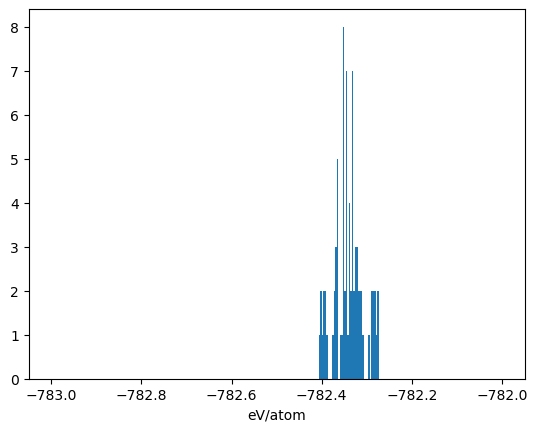

In [13]:
plt.hist(E, bins=300, range=[-783, -782])
plt.xlabel("eV/atom")

In [16]:
F


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1095,) + inhomogeneous part.

Text(0.5, 1.0, 'Forces in z')

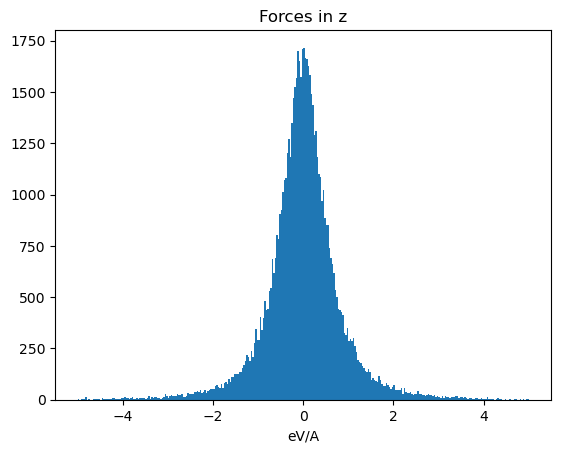

In [42]:
plt.hist(F, bins=300, range=[-5, 5])
plt.xlabel("eV/A")
plt.title("Forces in z")

(0.0, 50.0)

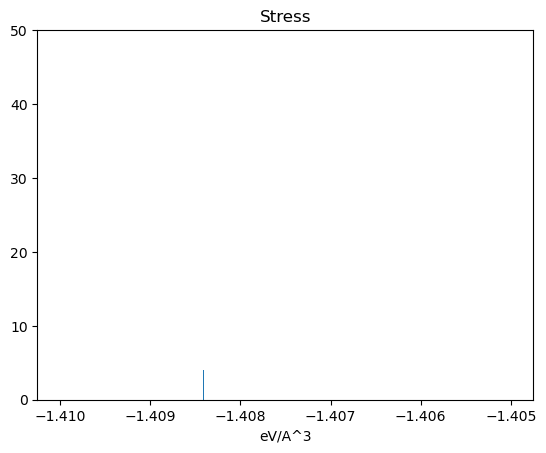

In [34]:
plt.hist(S, bins=300, range=[-1.41, -1.405])
plt.xlabel("eV/A^3")
plt.title("Stress")
plt.ylim([0,50])

In [61]:
df = pd.read_csv("/Users/Michael_wang/Documents/venkat/mint-PD/PhaseDiagram-Clease/nequip.csv")

In [62]:
df.columns

Index(['epoch', 'batch', 'loss', 'loss_f', 'loss_e', 'loss_stress', 'f_mae',
       'f_rmse', 'Li_f_mae', 'Cl_f_mae', 'K_f_mae', 'psavg_f_mae', 'Li_f_rmse',
       'Cl_f_rmse', 'K_f_rmse', 'psavg_f_rmse', 'e_mae', 'e/N_mae',
       'stress_mae', 'stress_rmse'],
      dtype='object')

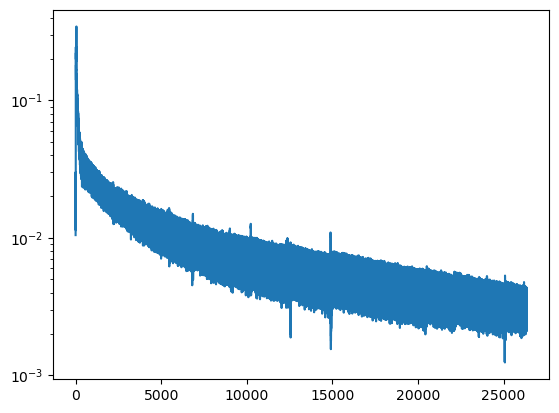

In [59]:
plt.semilogy(df[" stress_rmse"])

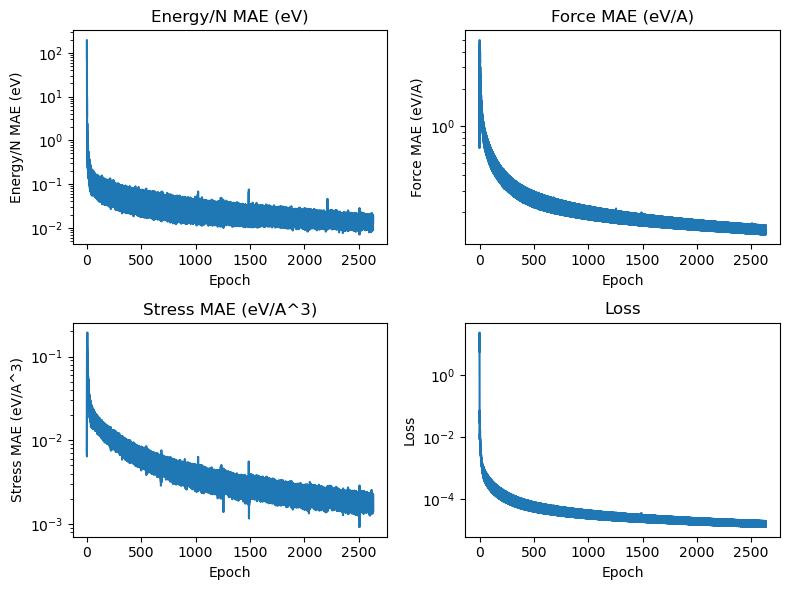

In [69]:
# Creating the 2x2 plot
fig, axs = plt.subplots(2, 2, figsize=(8, 6))  # Create a figure and a 2x2 grid of axes

# Plotting 'e/N_mae'
axs[0, 0].semilogy(df['epoch'], df['e/N_mae'])
axs[0, 0].set_title('Energy/N MAE (eV)')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Energy/N MAE (eV)')

# Plotting 'f_mae'
axs[0, 1].semilogy(df['epoch'], df['f_mae'])
axs[0, 1].set_title('Force MAE (eV/A)')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Force MAE (eV/A)')

# Plotting 'stress_mae'
axs[1, 0].semilogy(df['epoch'], df['stress_mae'])
axs[1, 0].set_title('Stress MAE (eV/A^3)')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Stress MAE (eV/A^3)')

# Plotting 'loss'
axs[1, 1].semilogy(df['epoch'], df['loss'])
axs[1, 1].set_title('Loss')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')

plt.tight_layout()  # Adjust the layout to make sure there's no overlap
plt.show()  # Display the plots

273.1404986381531


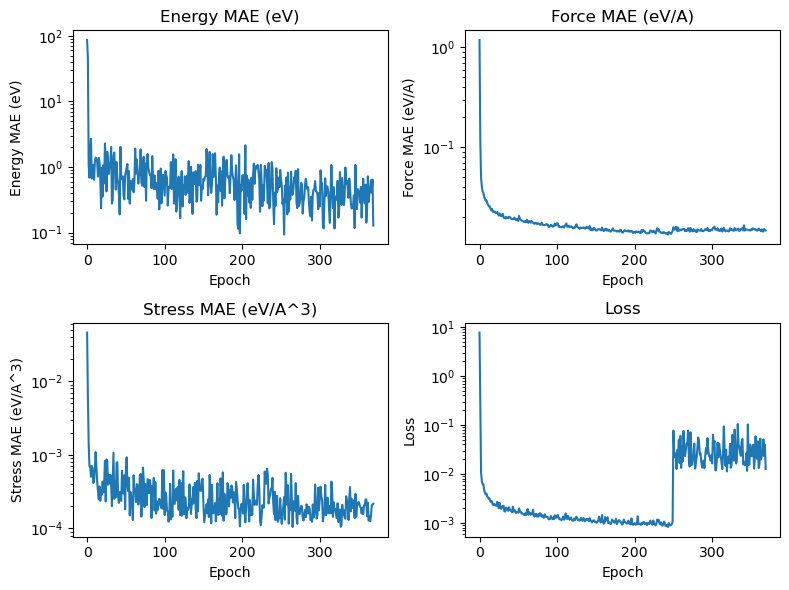

In [71]:
import json

# File path
file_path = '/Users/Michael_wang/Documents/venkat/mint-PD/PhaseDiagram-Clease/mace_fine_tunning_100_run-42_train.txt'

# Initialize lists to hold data
epochs = []
losses = []
mae_es = []
mae_fs = []
mae_stresses = []
time = []

# Read the file and extract data
with open(file_path, 'r') as file:
    for line in file:
        try:
            # Convert line to dictionary
            data = json.loads(line)

            # Check if all required keys are in the dictionary
            if all(key in data for key in ['loss', 'mae_e', 'mae_f', 'mae_stress', 'epoch']):
                # Append data to lists
                epochs.append(data['epoch'])
                losses.append(data['loss'])
                mae_es.append(data['mae_e'])
                mae_fs.append(data['mae_f'])
                mae_stresses.append(data['mae_stress'])
                time.append(data['time'])
        except json.JSONDecodeError:
            continue  # Skip lines that are not valid JSON

print(np.sum(time))

# Create a DataFrame
df = pd.DataFrame({
    'epoch': epochs,
    'loss': losses,
    'mae_e': mae_es,
    'mae_f': mae_fs,
    'mae_stress': mae_stresses
})

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(8, 6))  # Create a figure and a 2x2 grid of axes

# Plotting 'mae_e'
axs[0, 0].semilogy(df['epoch'], df['mae_e'])
axs[0, 0].set_title('Energy MAE (eV)')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Energy MAE (eV)')

# Plotting 'mae_f'
axs[0, 1].semilogy(df['epoch'], df['mae_f'])
axs[0, 1].set_title('Force MAE (eV/A)')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Force MAE (eV/A)')

# Plotting 'mae_stress'
axs[1, 0].semilogy(df['epoch'], df['mae_stress'])
axs[1, 0].set_title('Stress MAE (eV/A^3)')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Stress MAE (eV/A^3)')

# Plotting 'loss' using semilogy
axs[1, 1].semilogy(df['epoch'], df['loss'])
axs[1, 1].set_title('Loss')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')

plt.tight_layout()  # Adjust the layout to make sure there's no overlap
plt.show()  # Display the plots


In [ ]:
from ovito.io import import_file, export_file
from ovito.modifiers import CoordinationAnalysisModifier, TimeAveragingModifier
import numpy

In [ ]:
# Load a simulation trajectory consisting of several frames:
pipeline = import_file("input/simulation.dump")
print("Number of MD frames:", pipeline.source.num_frames)

# Insert the RDF calculation modifier into the pipeline:
pipeline.modifiers.append(CoordinationAnalysisModifier(cutoff = 5.0, number_of_bins = 200))

# Insert the time-averaging modifier into the pipeline, which accumulates
# the instantaneous DataTable produced by the previous modifier and computes a mean histogram.
pipeline.modifiers.append(TimeAveragingModifier(operate_on='table:coordination-rdf'))

# Data export method 1: Convert to NumPy array and write data to a text file:
total_rdf = pipeline.compute().tables['coordination-rdf[average]'].xy()
numpy.savetxt("output/rdf.txt", total_rdf)

# Data export method 2: Use OVITO's own export function for DataTable objects:
export_file(pipeline, "output/rdf.txt", "txt/table", key="coordination-rdf[average]")

In [3]:
tmp = read_lammps_data("/Users/Michael_wang/Documents/venkat/mint-PD/PhaseDiagram-Clease/LiKCl-chgnet-0.3.0-prod/0.10x-LiKCl-chgnet-0.3.0-prod/initial-solid.data")

['0.00x-LiKCl-chgnet-0.3.0-cell-relaxed', '0.10x-LiKCl-chgnet-0.3.0-cell-relaxed', '0.20x-LiKCl-chgnet-0.3.0-cell-relaxed', '0.30x-LiKCl-chgnet-0.3.0-cell-relaxed', '0.40x-LiKCl-chgnet-0.3.0-cell-relaxed', '0.50x-LiKCl-chgnet-0.3.0-cell-relaxed', '0.60x-LiKCl-chgnet-0.3.0-cell-relaxed', '0.70x-LiKCl-chgnet-0.3.0-cell-relaxed', '0.80x-LiKCl-chgnet-0.3.0-cell-relaxed', '0.90x-LiKCl-chgnet-0.3.0-cell-relaxed', '1.00x-LiKCl-chgnet-0.3.0-cell-relaxed']


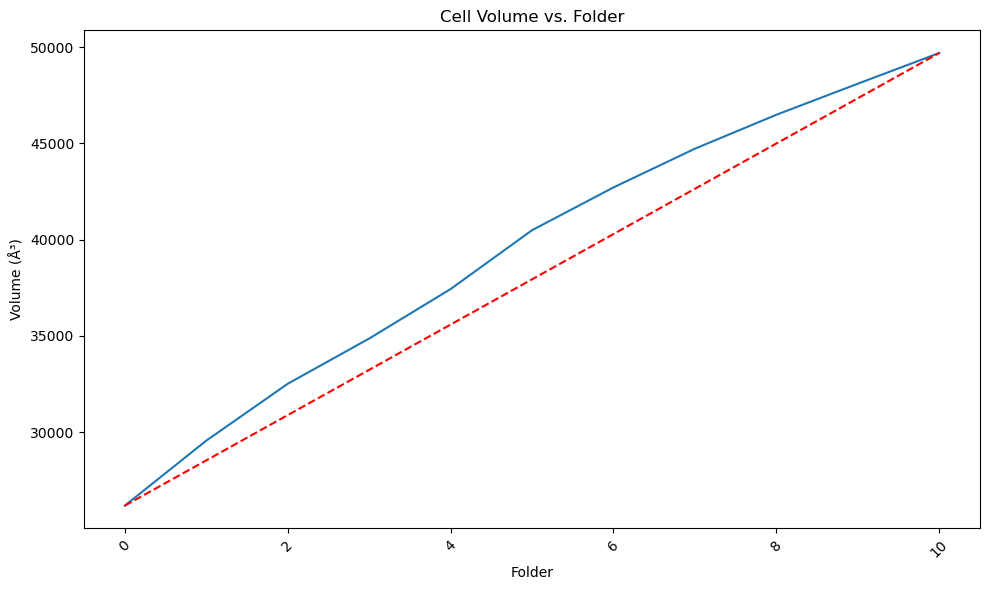

In [6]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read

def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

# Set the directory path
directory = "/Users/Michael_wang/Downloads/LiKCl-chgnet-0.3.0-cell-relaxed"

# Get all folders in the directory
folders = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]

# Sort the folder names
sorted_folders = sorted(folders)
print(sorted_folders)

# Initialize lists to store folder names and volumes
folder_names = []
volumes = []

# Iterate over the sorted folders
for folder in sorted_folders:
    # Construct the file path
    file_path = os.path.join(directory, folder, "initial-solid.data")
    
    # Check if the file exists
    if os.path.isfile(file_path):
        # Read the LAMMPS data file using ASE
        atoms = read_lammps_data(file_path)
        
        # Get the cell volume
        volume = atoms.get_volume()
        
        # Append the folder name and volume to the lists
        folder_names.append(folder)
        volumes.append(volume)

# Plot the volume against folder names
plt.figure(figsize=(10, 6))
plt.plot(volumes)
plt.plot([0, 10], [volumes[0], volumes[-1]], linestyle='--', color='red')  # Add this line
plt.xlabel("Folder")
plt.ylabel("Volume (Å³)")
plt.title("Cell Volume vs. Folder")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example 2x2x3x3 matrix (replace with your actual matrix)
matrix = np.random.rand(2, 2, 3, 3)

# Create a figure and axis
fig, ax = plt.subplots()

# Set up the grid
N = 3  # Change as necessary
points = np.arange(N * N).reshape(N, N)

# Draw the arrows based on the matrix values
for i in range(N):
    for j in range(N):
        # Horizontal arrows
        right_val = matrix[0, 0, i, j]
        left_val = matrix[0, 1, i, j]
        
        ax.annotate("", xy=(j + 1, N - 1 - i + 0.1), xytext=(j, N - 1 - i + 0.1), 
                    arrowprops=dict(facecolor=plt.cm.viridis(right_val), shrink=0.05))
        ax.annotate("", xy=(j, N - 1 - i - 0.1), xytext=(j + 1, N - 1 - i - 0.1), 
                    arrowprops=dict(facecolor=plt.cm.viridis(left_val), shrink=0.05))
        
        # Vertical arrows
        up_val = matrix[1, 0, i, j]
        down_val = matrix[1, 1, i, j]
        
        ax.annotate("", xy=(j - 0.1, N - 1 - i + 1), xytext=(j - 0.1, N - 1 - i), 
                    arrowprops=dict(facecolor=plt.cm.viridis(up_val), shrink=0.05))
        ax.annotate("", xy=(j + 0.1, N - 1 - i), xytext=(j + 0.1, N - 1 - i + 1), 
                    arrowprops=dict(facecolor=plt.cm.viridis(down_val), shrink=0.05))

# Set the aspect of the plot to be equal
ax.set_aspect('equal')

# Set axis limits
ax.set_xlim(-0.5, N - 0.5)
ax.set_ylim(-0.5, N - 0.5)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Add grid
ax.grid(True)

# Show the plot
plt.show()

In [2]:
tmp = read_lammps_data("/Users/Michael_wang/Documents/venkat/mint-PD/PhaseDiagram-Clease/LiKCl-CHGNET-finetuned/2.00x-LiKCl-CHGNET-finetuned/initial-solid.data")

In [ ]:
tmpCharge = tmpAtoms.numbers.copy()
tmpCharge[tmpCharge == 3] = 1
tmpCharge[tmpCharge == 17] = -1
tmpCharge[tmpCharge == 19] = 1
tmpAtoms.set_initial_charges(tmpCharge)